In [1]:
#%pip install lxml
import os
import s3fs
import gzip
import xml.etree.ElementTree as ET
#from lxml import etree
import pandas as pd
%pip install unidecode
from unidecode import unidecode
import re
import numpy as np

os.environ["AWS_ACCESS_KEY_ID"] = '1J9SZCURG0IZM0VVX37D'
os.environ["AWS_SECRET_ACCESS_KEY"] = '9CKCagFEDjzIKptrZy1sBOI2+C8+94ojH+LONi54'
os.environ["AWS_SESSION_TOKEN"] = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiIxSjlTWkNVUkcwSVpNMFZWWDM3RCIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNzYxNjM5MDM3LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6Imx1Y2FzLmN1bXVuZWxAZW5zYWUuZnIiLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiZXhwIjoxNzYyMjQzODYwLCJmYW1pbHlfbmFtZSI6IkN1bXVuZWwiLCJnaXZlbl9uYW1lIjoiTHVjYXMiLCJncm91cHMiOlsiVVNFUl9PTllYSUEiLCJzdGF0YXBwLXNlZ21lZGljIl0sImlhdCI6MTc2MTYzOTA2MCwiaXNzIjoiaHR0cHM6Ly9hdXRoLmxhYi5zc3BjbG91ZC5mci9hdXRoL3JlYWxtcy9zc3BjbG91ZCIsImp0aSI6Im9ucnRydDo4NzNjZTViNy04ZDQ3LWQ0NGItNDk3NC04NWNjNDA3NWJkZWUiLCJuYW1lIjoiTHVjYXMgQ3VtdW5lbCIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJsYWIiLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtc3NwY2xvdWQiXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJyb2xlcyI6WyJvZmZsaW5lX2FjY2VzcyIsInVtYV9hdXRob3JpemF0aW9uIiwiZGVmYXVsdC1yb2xlcy1zc3BjbG91ZCJdLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNpZCI6IjdlMzg4NmFiLWUxYWEtNDZiNS04MGE2LTRkNDRiYzk0NzJkZiIsInN1YiI6ImUyZDc4NjRjLTcwMzItNDI0ZC04OTA2LWU0ZjhiNDFjYzAwMyIsInR5cCI6IkJlYXJlciJ9.oBZKGdOLRwmoT9SUMM2H5RfIPMoP22e8cotzbdlOdtscV3mC6HL1vp72nuBvp6kMECQOlsOeqVY7rSfNnMm8Jw'
os.environ["AWS_DEFAULT_REGION"] = 'us-east-1'
fs = s3fs.S3FileSystem(
    client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},
    key = os.environ["AWS_ACCESS_KEY_ID"], 
    secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
    token = os.environ["AWS_SESSION_TOKEN"])
with fs.open("s3://lab/kgnd.csv") as f:
    kgnd = pd.read_csv(f)
with fs.open("s3://lab/fuzzed.csv") as f:
    fuzz1 = pd.read_csv(f)
with fs.open("s3://lab/fuzzed2.csv") as f:
    fuzz2 = pd.read_csv(f)
with fs.open("s3://lab/ignd.csv") as f:
    ignd = pd.read_csv(f)
with fs.open("s3://lab/wgnd.csv") as f:
    wgnd = pd.read_csv(f)
with fs.open("s3://lab/jgnd.csv") as f:
    jgnd = pd.read_csv(f)
with fs.open("s3://lab/main_df.parquet") as f:
    df = pd.read_parquet(f)
with fs.open("s3://lab/cgnd.csv") as f:
    cgnd = pd.read_csv(f)
with fs.open("s3://lab/usgnd.csv") as f: #coulmont
    usgnd = pd.read_csv(f)
with fs.open("s3://lab/Indian-Male-Names.csv") as f: #https://gist.github.com/mbejda/7f86ca901fe41bc14a63
    imnd = pd.read_csv(f)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
#df["name"]=df["ego"].str.lstrip().str.split(" ").str[0].str.lower()
df["name"]=df["name"].str.replace("-", " ").str.split(" ").str[0]
df["name"]=df["name"].fillna("").astype(str).apply(lambda x: unidecode(x))
fuzz=pd.concat([fuzz1,fuzz2],axis=0, ignore_index=True)
df = df.merge(fuzz, left_on='name', right_on='Name', how='left')
df['name'] = df['New_name'].combine_first(df['name'])
df["name"]=df["name"].apply(lambda x: re.sub(r'[^a-z\s]', '', x) if isinstance(x, str) else x)
df["name"] = df["name"].replace(r'^\s*([A-Za-z]{1})?\s*$', np.nan, regex=True)
df=df.drop(columns=["Name","New_name","Score"])

gnd=pd.concat([wgnd,cgnd,kgnd,ignd,jgnd,usgnd],axis=0,ignore_index=True)
gnd=gnd.drop(columns=["Count"])
df=df.merge(gnd.drop_duplicates(subset=["Name"]), how="left", left_on="name", right_on="Name")
df=df.drop(columns=["Name"])
df

,ego,coauthors,source,year,title,doi,Type,ego_number,name,Gender
0,Kodai Shimosato,Norimichi Ukita,CoRR,2024,Inpainting-Driven Mask Optimization for Object...,https://doi.org/10.48550/arXiv.2403.15849,art,None,kodai,M
1,Kodai Shimosato,Norimichi Ukita,IEEE Access,2021,Multi-Modal Data Fusion for Land-Subsidence Im...,https://doi.org/10.1109/ACCESS.2021.3120133,art,None,kodai,M
2,Norimichi Ukita,Kodai Shimosato,CoRR,2024,Inpainting-Driven Mask Optimization for Object...,https://doi.org/10.48550/arXiv.2403.15849,art,None,norimichi,M
3,Norimichi Ukita,"Arnau Raventos, Aryan Esfandiari, C. Victor J...",CoRR,2020,AIM 2020 Challenge on Video Extreme Super-Reso...,https://arxiv.org/abs/2009.06290,art,None,norimichi,M
4,Norimichi Ukita,"Kazutoshi Akita,Kyotaro Tokoro",CoRR,2024,Burst Super-Resolution with Diffusion Models f...,https://doi.org/10.48550/arXiv.2403.19428,art,None,norimichi,M
...,...,...,...,...,...,...,...,...,...,...
28630100,Geetanjali R. Kamath,,None,None,None,None,None,None,geetanjali,F
28630101,Shigeaki Matsuoka,,None,None,None,None,None,None,shigeaki,M
28630102,Martin Koppers,,None,None,None,None,None,None,martin,M
28630103,Ehren Dohler,,None,None,None,None,None,None,ehren,M


In [ ]:
df=df.replace([None, " " , ""], np.nan)
df["year"]=pd.to_numeric(df["year"], errors="coerce").astype("Int64")

#bornes temporelles
df=df[(df["year"]>1989)&(df["year"]<2025)]

#critères de qualité
df=df[~df["doi"].isna()]

In [ ]:
#MV
(df["Gender"].isna()).sum()/len(df)*100 #2.6% gender MV tot
(df["name"].isna()).sum()/len(df)*100 #2.5% name MV tot (2,4% is bc of initials)
(df.drop_duplicates(subset=["name"]).isna()).sum()/len(df.drop_duplicates(subset=["name"]))*100 #32.9% gender MV among all names
(df.drop_duplicates(subset=["ego"])["Gender"].isna()).sum()/len(df.drop_duplicates(subset=["ego"])) #0.03%

np.float64(0.034207818111946814)

In [ ]:
#Cov
df[df["Type"]=="inp"]["source"].nunique() #2k journals and 15k conferences
(df["Gender"]=="F").sum()/len(df)*100 #23.5% of F 1st authorship, 73.8 for M
(df.drop_duplicates(subset=["ego"])["Gender"]=="M").sum()/len(df.drop_duplicates(subset=["ego"]))*100 #66.2% of M, 30,3% of F

np.float64(66.28060062984649)

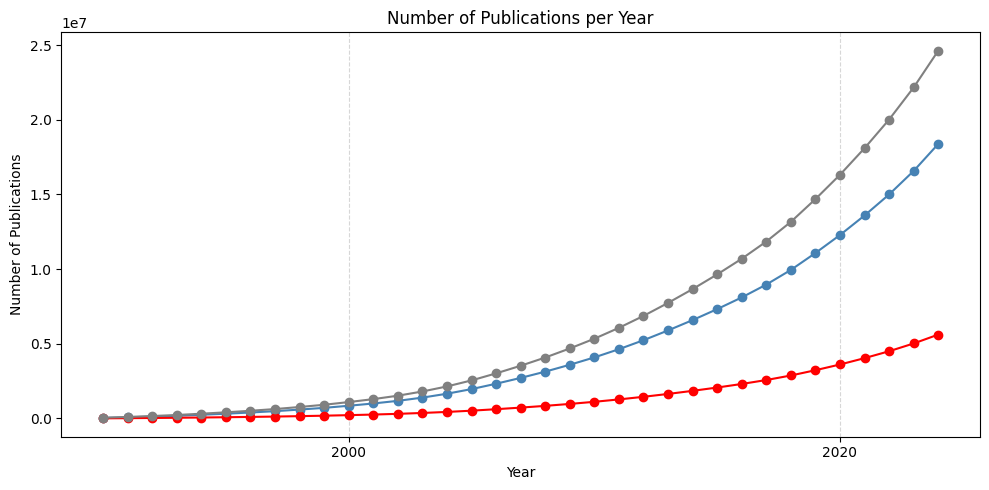

In [28]:
import matplotlib.pyplot as plt

pub=df["year"].value_counts().sort_index().cumsum()
gen=df.groupby(['year', 'Gender']).size().unstack(fill_value=0).cumsum()


plt.figure(figsize=(10,5))
plt.plot(gen.index, gen["M"], marker='o', color='steelblue')
plt.plot(gen.index, gen["F"], marker='o', color='red')
plt.plot(pub.index, pub.values, marker='o', color='grey')
plt.title("Number of Publications per Year")
plt.xlabel("Year")
plt.ylabel("Number of Publications")

import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
wgnd["Name"]=wgnd["Name"].str.replace("-", " ")
wgnd["Name"]=wgnd["Name"].fillna("").astype(str).apply(lambda x: unidecode(x))
wgnd["Name"]=wgnd["Name"].str.split(" ").str[0]
wgnd["Name"]=wgnd["Name"].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x) if isinstance(x, str) else x)

Note: you may need to restart the kernel to use updated packages.


In [3]:
cgnd["Name"]=cgnd["Chinese_Pinyin_name"]
mean_values = cgnd[['pinyin_male_prob_1980-1999', 'pinyin_male_prob_2000-2019']].mean(axis=1)

cgnd['Gender'] = None
cgnd.loc[mean_values > 0.6, 'Gender'] = 'M'
cgnd.loc[mean_values < 0.4, 'Gender'] = 'F'
cgnd=cgnd[["Name","Gender"]]

In [43]:
kgnd1["Name"]=kgnd1["name"].apply(lambda x: re.sub(r"[^가-힣\s]", "", str(x)).strip())
kgnd1["Name"]=kgnd1["Name"].fillna("").astype(str).apply(lambda x: unidecode(x))
kgnd1=kgnd1[["Name"]]
kgnd1["Gender"]="M"
kgnd2["Name"]=kgnd2["name"].apply(lambda x: re.sub(r"[^가-힣\s]", "", str(x)).strip())
kgnd2["Name"]=kgnd2["Name"].fillna("").astype(str).apply(lambda x: unidecode(x))
kgnd2=kgnd2[["Name"]]
kgnd2["Gender"]="F"
kgnd=pd.concat([kgnd1,kgnd2],axis=0,ignore_index=True)
kgnd

,Name,Gender
0,seojun,M
1,minjun,M
2,doyun,M
3,yejun,M
4,hajun,M
...,...,...
55498,sujannayeim,F
55499,sujannacaea,F
55500,sujannahyeon,F
55501,sujanmyeong,F


In [63]:
"""imnd["Name"]=imnd["name"]
imnd["Gender"]=imnd["gender"].str.upper()
imnd=imnd.drop(columns=["name","gender","race"])
imnd["Name"]=imnd["Name"].fillna("").astype(str).apply(lambda x: unidecode(x)).str.replace(" ","")
imnd["Name"]=imnd["Name"].apply(lambda x: re.sub(r"[^a-z]", "", str(x)).strip())
imnd
ignd=pd.merge(ignd,imnd, on="Name",how="outer").drop_duplicates()
ignd["Gender"]=ignd["Gender_x"].combine_first(ignd["Gender_y"])
ignd=ignd.drop(columns=["Gender_x","Gender_y"])"""
ignd["Name"]=ignd["Name"].apply(lambda x: re.sub(r"[^a-z]", "", str(x)).strip())
ignd

,Name,Gender
0,,M
24,shaurya,M
25,aabha,F
26,aabharana,F
27,aabheer,M
...,...,...
21887,zubin,M
21888,zuha,F
21889,zuhaibnasim,M
21890,zuri,F


In [ ]:
ignd1["Name"]=ignd1["name"]
ignd1=ignd1[["Name"]]
ignd1["Gender"]="M"
ignd2["Name"]=ignd2["name"]
ignd2=ignd2[["Name"]]
ignd2["Gender"]="F"
ignd=pd.concat([ignd1,ignd2],axis=0,ignore_index=True)
ignd["Name"]=ignd["Name"].str.lower()
ignd

,Name,Gender
0,aabheer,M
1,aadarsh,M
2,aadesh,M
3,aadhir,M
4,aadi,M
...,...,...
1175901,zuha,F
1175902,zuri,F
1175903,zuha,F
1175904,zuri,F


In [3]:
jap1["Gender"]="M"
jap1["Name"]=jap1["name"].str.lower()
jap1=jap1.drop(columns=["letter","page","name"])
jap2["Gender"]="F"
jap2["Name"]=jap2["name"].str.lower()
jap2=jap2.drop(columns=["letter","page","name"])
jgnd=pd.merge(jap1,jap2, on="Name", how="outer")
jgnd["Gender"]=jgnd["Gender_x"].apply(lambda x: "F" if pd.isna(x) else x) #unisex = M
jgnd=jgnd.drop(columns=["Gender_x","Gender_y"])
jgnd

,Name,Gender
0,aachi,F
1,aamu,F
2,aasa,F
3,aasu,M
4,aata,M
...,...,...
20898,zozo,M
20899,zuihou,M
20900,zuimaru,M
20901,zuimu,M


In [ ]:
us_list = fs.glob("s3://lab/yob????.txt")
df=pd.DataFrame()
for i in us_list :
    with fs.open(f"s3://{i}") as f:
        temp = pd.read_csv(f, header=None, names=['Name', 'Gender', 'Count'])
    df=pd.concat([df,temp], axis=0,ignore_index=True)


In [16]:
def prep(names) :
    names["Name"]=names["name"]
    names=names.drop(columns=["name"])
    names["Name"]=names["Name"].str.replace("-", " ")
    names["Name"]=names["Name"].str.split(" ").str[0]
    names["Name"]=names["Name"].fillna("").astype(str).apply(lambda x: unidecode(x))
    names["Name"]=names["Name"].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x) if isinstance(x, str) else x)
    return names
conf_names=prep(conf_names)
art_names=prep(art_names)
names=pd.concat([art_names,conf_names],axis=0,ignore_index=True)

In [17]:
fuzz=pd.concat([fuzz1,fuzz2],axis=0, ignore_index=True)
names = names.merge(fuzz, left_on='Name', right_on='Name', how='left')
names['Name'] = names['New_name'].combine_first(names['Name'])
names=names.drop(columns=["New_name","Score"])
names

,Name
0,kodai
1,norimichi
2,ameya
3,george
4,kenji
...,...
403975,mhanaj
403976,johannan
403977,mamfe
403978,nopparat


In [ ]:
gnd=pd.concat([wgnd,cgnd,kgnd,ignd,jgnd,usgnd],axis=0,ignore_index=True)
match_df = names.drop_duplicates().merge(gnd.drop_duplicates(), how="left", on="Name")
(match_df["Gender"].isna()).sum()/len(match_df)*100 #26,2%   55,6% art, 50,9% conf, 32% conf 37% art avec chinois 30.6% conf 36% art avec coréen 30.4% 35.9% avec indien 35,8
#(match_df["Gender"]=="F").sum()/len(match_df)*100 #24,8%    21% conf 20% art F 

np.float64(24.82474132822827)

In [ ]:
#%pip install rapidfuzz
from rapidfuzz import fuzz
import pandas as pd
from collections import defaultdict

# Threshold for similarity (0-100)
SIMILARITY_THRESHOLD = 90  # Adjust as needed

# Build dictionary groups by first two letters
def build_prefix_dict(df):
    prefix_dict = defaultdict(list)
    for name in df["Name"]:
        if isinstance(name, str):
            prefix = name[:2].lower()
            prefix_dict[prefix].append(name)
    return prefix_dict


def match_name_fast(name, prefix_dict, threshold=SIMILARITY_THRESHOLD):
    """
    Returns first acceptable match (>= threshold) in the relevant prefix group.
    Stops early once threshold met.
    """
    if not isinstance(name, str) or len(name) < 1:
        return None, None

    prefix = name[:2].lower()
    candidates = prefix_dict.get(prefix, [])

    for candidate in candidates:
        score = fuzz.ratio(name, candidate)
        if score >= threshold:
            return candidate, score  # early stop once threshold reached

    return None, None


# Example usage:
# match_df = pd.read_csv("to_match.csv")
# gnd = pd.read_csv("dictionary.csv")

prefix_dict = build_prefix_dict(gnd)
mr = []

for name in match_df[match_df["Gender"].isna()]["Name"]:
    matched_name, score = match_name_fast(name, prefix_dict)
    mr.append((name, matched_name, score))

# Add results to DataFrame
#match_df["Matched_Name"] = [m[1] for m in matched_results]
#match_df["Score"] = [m[2] for m in matched_results]

print("Matching completed!")

# Optional: Save to CSV
# match_df.to_csv("matched_names.csv", index=False)



In [1]:
mr

NameError: name 'mr' is not defined

In [32]:
sum(t[1]==None for t in mr)
df = pd.DataFrame(mr, columns=["Name", "New_name", "Score"])
df[~df["Score"].isna()]

,Name,New_name,Score
304,masataro,masatarou,94.117647
316,tetsuyou,tetsuou,93.333333
417,heishiro,heishirou,94.117647
589,toyotaro,toyotarou,94.117647
748,reiichiro,reiichirou,94.736842
...,...,...,...
79994,ryoshin,ryoushin,93.333333
79995,hauren,hakuren,92.307692
80576,makitaro,makitarou,94.117647
80619,norizo,norizou,92.307692


In [38]:
match_df[match_df["Gender"].isna()]["Name"]#gnd[~gnd['Name'].isin(match_df[~match_df.isna()]["Name"])]

18                  
39              shyh
44            lappui
132            magns
135         fabrycio
             ...    
248745    koshichiro
248748        capron
248749        museok
248751        mhanaj
248753      mamfeter
Name: Name, Length: 80545, dtype: object

In [19]:
#visualiser
import math
import numpy as np
feur=df[df["Gender"].isna()]["name"]
n = int(math.sqrt(len(feur)))
matrix = np.array(feur[:n*n]).reshape(n, n)
pd.DataFrame(matrix).to_csv("feur.csv",index=False)

In [41]:
ignd.drop_duplicates()

,Name,Gender
0,aabheer,M
1,aadarsh,M
2,aadesh,M
3,aadhir,M
4,aadi,M
...,...,...
1174998,zora,F
1174999,zoya,F
1175000,zoyel,F
1175001,zuha,F


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

HEADERS = {"User-Agent": "Friendly scraper"}

def scrape_page(page_number):
    url = f"https://korean-name.com/en/ranking/{page_number}"
    r = requests.get(url, headers=HEADERS, timeout=10)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")

    # Scrape boy table
    boy_table = soup.select_one(
        "div.real-wrapper > div.wrapper > div.section > div.baby--normal-flex-container > div.half-table > table#tbl-rank-boy"
    )
    boy_data = []
    if boy_table:
        for row in boy_table.select("tr"):
            cols = row.select("td")
            if len(cols) >= 2:
                rank = cols[0].get_text(strip=True)
                name = cols[1].get_text(strip=True)
                boy_data.append({"rank": rank, "name": name})

    # Scrape girl table
    girl_table = soup.select_one(
        "div.real-wrapper > div.wrapper > div.section > div.baby--normal-flex-container > div.half-table > table#tbl-rank-girl"
    )
    girl_data = []
    if girl_table:
        for row in girl_table.select("tr"):
            cols = row.select("td")
            if len(cols) >= 2:
                rank = cols[0].get_text(strip=True)
                name = cols[1].get_text(strip=True)
                girl_data.append({"rank": rank, "name": name})

    return boy_data, girl_data

# Example: scrape pages 1 to 5 with cooldown
all_boy_data = []
all_girl_data = []

for page_num in range(1, 280):  # adjust page range as needed
    print(f"Scraping page {page_num}...")
    boy_data, girl_data = scrape_page(page_num)
    all_boy_data.extend(boy_data)
    all_girl_data.extend(girl_data)
    
    time.sleep(random.uniform(1, 3))  # cooldown

# Convert to DataFrames
df_boys = pd.DataFrame(all_boy_data)
df_girls = pd.DataFrame(all_girl_data)

print("Boys DF:")
print(df_boys.head())
print("\nGirls DF:")
print(df_girls.head())


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scraping page 50...
Scraping 

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import random
import string  # for letters a–z

HEADERS = {"User-Agent": "Friendly scraper"}

base_url = "https://indianhindunames.com/indian-hindu-girl-name-{}.htm"

all_data = []

for letter in string.ascii_lowercase:  # 'a' to 'z'
    url = base_url.format(letter)
    print(f"Scraping {url} ...")

    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"❌ Failed to fetch {url}: {e}")
        continue

    soup = BeautifulSoup(r.text, "html.parser")

    name_lists = soup.select("ul.list-group.namelist")

    for ul in name_lists:
        items = ul.select("li")
        for li in items:
            raw_text = li.get_text(" ", strip=True)

            # Extract names before "="
            names = re.findall(r"([^\s=]+)\s*=", raw_text)
            for n in names:
                n_clean = n.strip()
                if n_clean:
                    all_data.append({"name": n_clean, "letter": letter})

    # polite random cooldown (1–3 seconds)
    time.sleep(random.uniform(1, 3))

# Convert all scraped data into one DataFrame
df = pd.DataFrame(all_data)

print(f"\n✅ Scraping complete! Total names collected: {len(df)}")
print(df.head())


Scraping https://indianhindunames.com/indian-hindu-girl-name-a.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-b.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-c.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-d.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-e.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-f.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-g.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-h.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-i.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-j.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-k.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-l.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-m.htm ...
Scraping https://indianhindunames.com/indian-hindu-girl-name-n.htm ...
Scrapi

In [69]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.wikidata.org/wiki/Wikidata:WikiProject_Names/lists/Korean_names'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
response.raise_for_status()
soup = BeautifulSoup(response.text, 'html.parser')

content = soup.find('div', class_='mw-parser-output')

def extract_names(gender_keyword):
    """Extract names table following a header containing gender_keyword"""
    for h2 in content.find_all('h2'):
        if gender_keyword in h2.get_text(strip=True).lower():
            table = h2.find_next('table', class_='wikitable sortable')
            if table:
                names = [row.find_all('td')[0].get_text(strip=True) 
                         for row in table.find_all('tr')[1:]  # skip header
                         if row.find_all('td')]
                return pd.DataFrame({'name': names})
    return pd.DataFrame({'name': []})

df_female = extract_names('female given name')
df_male = extract_names('male given name')

print("Female names:", df_female.head())
print("Male names:", df_male.head())


Female names:          name
0      Eun-ju
1    Bo-yeong
2  Chae-yeong
3     Chun-ja
4       Eun-a
Male names:          name
0      Eun-ju
1    Bo-yeong
2  Chae-yeong
3     Chun-ja
4       Eun-a


In [ ]:
df_female["Gender"]="F"
df_male["Gender"]="M"
df=pd.concat([df_female,df_male],axis=0,ignore_index=True)
df["Name"]=df["name"].str.lower()
df=df[["Name","Gender"]]


In [77]:
df['Name'] = df['Name'].str.replace(r'[^\w\s]', '', regex=True)
df

,Name,Gender
0,eunju,F
1,boyeong,F
2,chaeyeong,F
3,chunja,F
4,euna,F
...,...,...
923,yangsun,M
924,daseul,M
925,seungsin,M
926,sunsil,M


In [80]:
df=df.drop_duplicates()
kgnd=kgnd.drop_duplicates()
kgnd=pd.concat([kgnd,df],axis=0,ignore_index=True)
kgnd

,Name,Gender
0,seojun,M
1,minjun,M
2,doyun,M
3,yejun,M
4,hajun,M
...,...,...
51629,yangsun,M
51630,daseul,M
51631,seungsin,M
51632,sunsil,M


In [ ]:
import asyncio
import string
import pandas as pd
from playwright.async_api import async_playwright

BASE_URL = "https://japanese-names.info/first-names/gender/{gender}-name/start-with-{letter}"
GIRL = "girl"
BOY = "boy"

async def scrape_page(page, url):
    """Scrape one page and return list of names"""
    await page.goto(url, timeout=0)
    # Wait for names to load
    try:
        await page.wait_for_selector("ul.name-list li h3", timeout=5000)
    except:
        return []  # no names on this page

    # Scroll to ensure dynamic content loads
    previous_height = await page.evaluate("document.body.scrollHeight")
    while True:
        await page.evaluate("window.scrollTo(0, document.body.scrollHeight);")
        await page.wait_for_timeout(1000)
        current_height = await page.evaluate("document.body.scrollHeight")
        if current_height == previous_height:
            break
        previous_height = current_height

    # Extract names
    name_elements = await page.query_selector_all("ul.name-list li h3")
    names = [await el.evaluate("(node) => node.textContent.trim()") for el in name_elements if await el.evaluate("(node) => node.textContent.trim()")]
    return names

async def scrape_gender(gender):
    all_data = []
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/118.0.5993.118 Safari/537.36"
        )
        page = await context.new_page()

        for letter in string.ascii_lowercase:
            page_num = 1
            while True:
                if gender == GIRL:
                    url = f"{BASE_URL.format(gender=gender, letter=letter)}/page/{page_num}/"
                else:  # boys have no page number on single-page
                    url = f"{BASE_URL.format(gender=gender, letter=letter)}" if page_num == 1 else f"{BASE_URL.format(gender=gender, letter=letter)}/page/{page_num}/"

                names = await scrape_page(page, url)
                if not names:
                    break  # stop if page has no names

                # Append data
                for name in names:
                    all_data.append({"letter": letter, "page": page_num, "name": name})

                page_num += 1

        await browser.close()

    return pd.DataFrame(all_data)

async def main():
    print("Scraping girl names...")
    #girls_df = await scrape_gender(GIRL)
    #print(f"Found {len(girls_df)} girl names ✅")

    print("Scraping boy names...")
    boys_df = await scrape_gender(BOY)
    print(f"Found {len(boys_df)} boy names ✅")

    # Save to CSV if needed
    #girls_df.to_csv("japanese_girl_names.csv", index=False)
    #boys_df.to_csv("japanese_boy_names.csv", index=False)

    return boys_df#, boys_df

# In Jupyter, use:
boys_df = await main()


In [ ]:
#names.to_parquet("conf_names.parquet", index=False)
s3_path = "s3://lab/main.csv"  # bucket + key

# Save directly to MinIO
df.to_csv(s3_path, index=False)

In [4]:
gdf["Gender"] = (
    gdf["Gender"]
    .astype(str)         # convert to string
    .str.strip()         # remove spaces
    .str.lower()         # normalize case
    .map({'m': 0, 'f': 1, 'male': 0, 'female': 1})
)
gdf["Name"]=gdf["Name"].str.lower()
gdf=gdf[~gdf["Gender"].isna()]

In [6]:
import unicodedata
import re

def normalize_name(name):
    if not isinstance(name, str):
        return ""
    # Lowercase
    name = name.lower().strip()
    # Remove accents (é → e, ü → u)
    name = ''.join(
        c for c in unicodedata.normalize('NFKD', name)
        if not unicodedata.combining(c)
    )
    # Remove punctuation, numbers, multiple spaces
    name = re.sub(r'[^a-z\s]', '', name)
    name = re.sub(r"^(?:[a-z]\s+)+", "", name)  # start
    name = re.sub(r"(?:\s+[a-z])+$", "", name)  # end
    name = re.sub(r'\s+', ' ', name).strip()
    return name

names["name"] = names["name"].apply(normalize_name)
gdf["Name"] = gdf["Name"].apply(normalize_name)

In [ ]:
%pip install rapidfuzz
from rapidfuzz import process, fuzz
# Get first 2 letters of all names
name_prefixes = names['Name'].str[:2].str.lower().unique()

# Filter gdf rows that match any of these prefixes
cand = gdf[gdf['Name'].str[:2].str.lower().isin(name_prefixes)]
print(cand)
matches = []
for n in match_df[match_df["Gender"].isna()]["Name"] :
    match, score, _ = process.extractOne(n, cand["Name"], scorer=fuzz.WRatio)
    matches.append({"name": n, "matched_name": match, "score": score})
matches_df = pd.DataFrame(matches)

             Name  Gender
0           james     0.0
1            john     0.0
2          robert     0.0
3         michael     0.0
4         william     0.0
...           ...     ...
22140406     kaki     1.0
22147959  antonei     1.0
22177245   millet     1.0
22186057    hayou     1.0
22188929   akishi     1.0

[2737230 rows x 2 columns]


KeyboardInterrupt: 

In [ ]:
%pip install rapidfuzz
from rapidfuzz import process, fuzz


name_prefixes = names['Name'].str[:2].str.lower().unique()

# Filter gdf rows that match any of these prefixes
cand = gdf[gdf['Name'].str[:2].str.lower().isin(name_prefixes)]

matches = []

for name in match_df[match_df["Gender"].isna()]["Name"]:
    # extractOne stops at first match with high enough score
    res = process.extractOne(
        query=name,
        choices=cand["Name"].tolist(),
        scorer=fuzz.WRatio,
        score_cutoff=95  # stop if score >= 95
    )
    
    if res is None:
        matches.append({"name": name, "match": None, "score": None})
    else:
        match, score, _ = res
        matches.append({"name": name, "match": match, "score": score})

import pandas as pd
matches_df = pd.DataFrame(matches)
print(matches_df)

KeyboardInterrupt: 

In [13]:
%pip install rapidfuzz
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, process
import re, unicodedata

# ---------------------------
# 1. Pre-cleaning function
# ---------------------------
def clean_name(name):
    if not isinstance(name, str):
        return ""
    name = name.lower().strip()
    # Remove accents
    name = ''.join(c for c in unicodedata.normalize('NFKD', name) if not unicodedata.combining(c))
    # Keep only letters and spaces
    name = re.sub(r"[^a-z\s-]", "", name)
    # Normalize spaces
    name = re.sub(r"\s+", " ", name).strip()
    return name

# Example: your datasets
names['clean'] = names['Name'].apply(clean_name)
gdf['clean'] = gdf['Name'].apply(clean_name)

# ---------------------------
# 2. Blocking by first N letters
# ---------------------------
BLOCK_N = 2
names['prefix'] = names['clean'].str[:BLOCK_N]
gdf['prefix'] = gdf['clean'].str[:BLOCK_N]

# ---------------------------
# 3. Chunked vectorized matching
# ---------------------------
results = []

for prefix, name_group in names.groupby('prefix'):
    # Candidates with same prefix
    candidates = gdf[gdf['prefix'] == prefix]['clean'].tolist()
    if not candidates:
        continue
    
    # Chunk names if group is too large
    CHUNK_SIZE = 50000
    for i in range(0, len(name_group), CHUNK_SIZE):
        chunk = name_group.iloc[i:i+CHUNK_SIZE]
        queries = chunk['clean'].tolist()
        
        # Compute similarity matrix (vectorized)
        # Returns best match and score for each query
        scores = process.cdist(queries, candidates, scorer=fuzz.WRatio, score_cutoff=92, processor=None, workers=-1)
        
        for q_idx, row in enumerate(scores):
            if np.all(np.isnan(row)):  # no match above cutoff
                results.append({"name": queries[q_idx], "match": None, "score": None})
            else:
                # index of best match
                best_idx = np.nanargmax(row)
                results.append({
                        "name": queries[q_idx],
                        "match": candidates[best_idx],
                        "score": row[best_idx]
                })

# ---------------------------
# 4. Create DataFrame of results
# ---------------------------
matches_df = pd.DataFrame(results)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.0 MB/s  0:00:00m0:00:01
Note: you may need to restart the kernel to use updated packages.


In [21]:
feur=matches_df[matches_df["score"]!=0]#[~matches_df["score"].isin([0, 100])]
matches_df#.drop_duplicates()

,name,match,score
0,,,0.0
1,,,0.0
2,,,0.0
3,a,a,100.0
4,a,a,100.0
...,...,...,...
246948,zygfryd,zygfryd,100.0
246949,zydrune,zyaire,0.0
246950,zz,zzyzx,0.0
246951,zzilia,zzyzx,0.0


In [126]:
name_map = dict(zip(feur["name"], feur["match"]))

# Replace in gdf
gdf["clean"] = gdf["clean"].map(name_map)#.fillna(gdf["clean"])
"""
match_df = names[["clean"]].merge(gdf[["clean","Gender"]], how="left", on="clean")
match_df[~match_df["Gender"].isna()]"""
gdf


/tmp/ipykernel_6688/200273274.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf["clean"] = gdf["clean"].map(name_map)#.fillna(gdf["clean"])


,Name,Gender,clean,prefix
0,james,0.0,james,ja
1,john,0.0,john,jo
2,robert,0.0,robert,ro
3,michael,0.0,michael,mi
4,william,0.0,william,wi
...,...,...,...,...
22140406,kaki,1.0,kaki,ka
22147959,NaN,1.0,NaN,an
22177245,NaN,1.0,NaN,mi
22186057,NaN,1.0,NaN,ha


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [81]:
g2['Name'] = g2['Name'].str.lower()
g2['Gender'] = g2['Gender'].map({'M': 0, 'F': 1})
#g2 = g2.drop_duplicates()

In [83]:
X = g2['Name']
y = g2['Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.fillna("")
X_test = X_test.fillna("")

In [84]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='char', ngram_range=(2, 3))),
    ('classifier', MultinomialNB())
])
pipeline.fit(X_train, y_train)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [94]:
#print(pipeline.score(X_test,y_test))
name = ["danjian"]
pipeline.predict(name)

array([0])

In [76]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6894255984098284


In [ ]:
import joblib
joblib.dump(pipeline, "gender_predictor_pipeline.pkl")

In [55]:
import re
d=g2.copy()
d["Name"] = d["Name"].str.replace(r'[^\w\s\u4E00-\u9FFF\u3400-\u4DBF\u3040-\u30FF\uAC00-\uD7AF]', '', regex=True)
kanji_pattern = re.compile(r'[\u4E00-\u9FFF\u3400-\u4DBF\u3040-\u30FF\uAC00-\uD7AF]')

mask = d["Name"].notna() & d["Name"].apply(lambda x: isinstance(x, str))
_kanji = d.loc[mask, "Name"].apply(lambda x: bool(kanji_pattern.search(x)))

df_latin = d.loc[_kanji.index[~_kanji]]

In [56]:
df_latin

,Name,Gender
0,baby,F
1,aisyah,F
2,anela,F
3,anela,F
4,fiyinfoluwa,F
...,...,...
21173433,abd alhamid,M
21173434,abdullah,M
21173435,abdullah,M
21173436,abdullah,M
